In [42]:
#Importing useful packages
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage.draw import polygon
from skimage import color
from copy import deepcopy
import time

In [5]:
!pip install scikit-image

## Gabor Filters as atoms of a Complex Cell

**Gabor Filters**:- Gabor Filters are a special type of filter which find a great deal of resemblance with Human Visual Cortex, more the reason we're trying to reproduce it in a Cog sc. class :). These filters possess localization properties, and allow a certain range of frequency to pass through while restricting others. Or, we're looking forward to passing features at a particular orientation.

We'll be using Gabor filter with only a real component for our purpose, the expression is given by:-

$$ g(x,y; \lambda, \theta, \phi, \sigma, \gamma) = \exp(- \frac{x^{'2} + \gamma^2 y^{'2}}{2\sigma^2}) cos(2\pi\frac{x'}{\lambda}+\phi) $$

Where:-

$ x'  = x\:cos \theta + y\:sin \theta $

$ y'  = -x\:sin \theta + y\:cos \theta $

$ \lambda $ = Wavelength of the sinusoidal component 

$ \theta $ = The angle of the normal to parallel stripes of gabor function 

$ \phi $ = The phase offset of sin function 

$ \sigma $ = The std dev of gaussian 

$ \gamma $ = Spatial aspect ratio specifying ellipticity of Gaussian  


For our application of reproducing the mechanism of Human Visual Cortex for identifying squares and triangles, we'll be tuning above hyperparameters to check which suits best for identifying both the figures.

In [3]:
class filters:
    '''Essentially a module dedicated to square gabor filters'''
    
    def __init__(self, theta, sigma=2, Lambda=4, phi=0, gamma=2):
        self.sigma=sigma
        self.theta=theta
        self.Lambda=Lambda
        self.phi=phi
        self.gamma=gamma
        
    '''Source:-https://en.wikipedia.org/wiki/Gabor_filter'''

    #Utility function to implement gabor filter
    def gabor(self,ksize):
        """Gabor feature extraction."""
        sigma_x = self.sigma

        sigma_y=self.sigma

        # Bounding box
        xmax=ksize/2
        ymax=ksize/2
        
        xmin = -xmax
        ymin = -ymax
       
        (x,y)=np.meshgrid(np.arange(xmin, xmax ),np.arange(ymin, ymax ))
        
        # Rotation
        y_theta = x * np.cos(self.theta) + y * np.sin(self.theta)
        x_theta = -x * np.sin(self.theta) + y * np.cos(self.theta)

        gb = np.exp(-.5 * (x_theta ** 2 / sigma_x ** 2 + ((y_theta ** 2 + self.gamma**2) / sigma_y ** 2))) * np.cos((2 * np.pi / self.Lambda * x_theta + self.phi))
        return gb
    


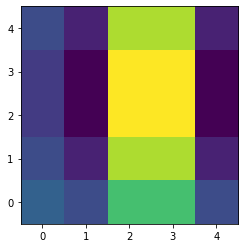

In [4]:
'''Visualising 5*5 gabor filter'''

fp=filters(theta=np.pi/2) #Note:-Angles are expressed in radians
plt.imshow(fp.gabor(5), origin='lower')
plt.show()

The above image demonstrates a gabor filter with theta=90 degrees, or it's vertical as expected, and will allow vertical lines to pass through while restricting others.

In [5]:
def triangle(x0,y0):
    '''Takes in the centre coordinate of an equilateral triangle and returns coordinates of all the 3 vertices'''
    
    d=20 #Distance of the centre from all the 3 vertices
    angle=np.pi/6
    rr,cc=[y0-d*np.sin(angle),y0-d*np.sin(angle),y0+d],[x0-d*np.cos(angle),x0+d*np.cos(angle),x0]
   
    
    return rr,cc

def squares(x0,y0):
    
    '''Takes in the centre coordinate of a square and returns coordinates of all 4 vertices of a square'''
    
    d=20
    angle=np.pi/4
    rr,cc=[y0-d*np.sin(angle),y0-d*np.sin(angle),y0+d*np.sin(angle), y0+d*np.sin(angle)],[x0-d*np.cos(angle),x0+d*np.cos(angle),x0+d*np.cos(angle),x0-d*np.cos(angle)]
   
    return rr,cc


    
    
    

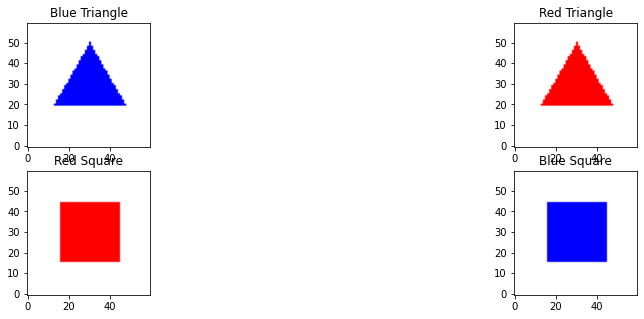

In [6]:
'''Using our utility functions to draw triangles and squares of 2 different colors namely red, blue'''

triangle_space=np.ones((60,60,3))

rr1,cc1=triangle(30,30)

rr1,cc1=polygon(rr1,cc1, triangle_space.shape)

square_space=np.ones((60,60,3))
rr2,cc2=squares(30,30)
rr2,cc2=polygon(rr2,cc2,square_space.shape)
square_space[rr2,cc2,:]=(0,0,1)

fig,ax=plt.subplots(2,2,figsize=[16,5])

triangle_space[rr1,cc1,:]=(0,0,1)
tri_blue=triangle_space

ax[0,0].imshow(tri_blue,origin='lower')
ax[0,0].set_title('Blue Triangle')

triangle_space[rr1,cc1,:]=(1,0,0)
tri_red=triangle_space

ax[0,1].imshow(tri_red,origin='lower')
ax[0,1].set_title('Red Triangle')
square_space[rr2,cc2,:]=(1,0,0)
sq_red=square_space

ax[1,0].imshow(sq_red,origin='lower')
ax[1,0].set_title('Red Square')

square_space[rr2,cc2,:]=(0,0,1)
sq_blue=square_space
ax[1,1].imshow(sq_blue,origin='lower')
ax[1,1].set_title('Blue Square')
plt.show()

In [173]:
triangle_space.shape

(60, 60, 3)

In [7]:
def filter_bank(figure, plot):
    
    '''Creates an array of filters with 4 diff. orientations and returns the convolved image, which wil help us to figure out 
    the response that the filter had on convolving with the image at diff. orientations'''
    
    
    #We want filters corresponding to alignment of edges w.r.t x axis
    angles=[0,np.pi/3, np.pi/2, 2*np.pi/3]
    
    #Threshold values are set based on empirical observations 
   
    conv_responses=[]
    bank=[filters(theta=0),filters(theta=np.pi/3),filters(theta=np.pi/2), filters(theta=2*np.pi/3)]
    bank=[]
    for i in range(len(angles)):
        
        bank.append(filters(theta=angles[i]))
    #0, 60, 90, 120 degrees respectively
    
    if(plot):
        fig,ax=plt.subplots(2,2,figsize=[10,5])
    figure=color.rgb2gray(figure)
    response=np.zeros(4)
    conv_images=[]
    for i in range(len(bank)):
        
        kernel=bank[i].gabor(ksize=11)
       
        convolved_img=ndi.convolve(figure,kernel)
        
#         convolved_img[convolved_img<0.7]=0
        convolved_img[convolved_img<0.85]=0
        
#         convolved_img[convolved_img>=0.85]=(1,0,0)
        conv_images.append(convolved_img)
        if(plot==True):
            ax[int(i/2),int(i%2)].imshow(convolved_img,origin='lower')
            ax[int(i/2),int(i%2)].set_title("GaborKernel at "+str(np.ceil(angles[i]*180/np.pi))+" degree")
            ax[int(i/2),int(i%2)].axis("off")
           
        
        conv_responses.append(convolved_img.mean())
       
    
    tri_check=conv_responses[0]+conv_responses[1]+conv_responses[3]
    sq_check=conv_responses[0]+ conv_responses[2]
    
    if(tri_check> sq_check):
        
        or_2=np.logical_or(conv_images[0],conv_images[1])
        return (np.logical_or(or_2,conv_images[3]),"Triangle")
    
    elif(sq_check>tri_check):
        
        return (np.logical_or(conv_images[0],conv_images[2]),"Square")
    
    else:
        return (0,"Empty")
        
   


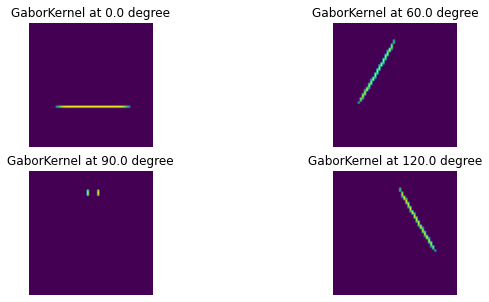

In [8]:
tri,_=filter_bank(deepcopy(triangle_space),plot=True)    


From the above plots, we can claim that our filters are doing a great job in passing those edges of the triangle which have the same orientation as the filter and filtering away the rest. Combining 3 detected edges, we can resconstruct the original triangle as shown in the following section:

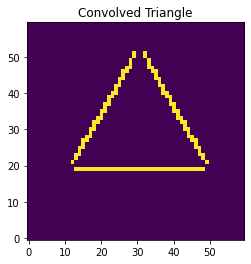

In [9]:
plt.imshow(tri, origin='lower')
plt.title('Convolved Triangle')
plt.show()

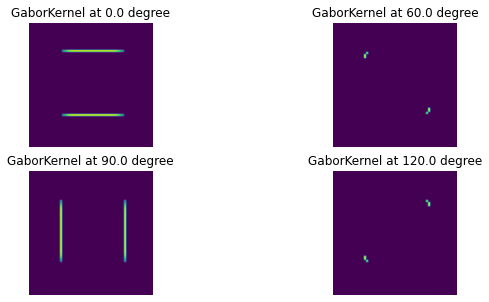

In [10]:
sq,_=filter_bank(deepcopy(square_space),plot=True)


For identifying a square, only 2 types of orientations are required to recognize a square, and combining those we have our outline of the square plotted below:

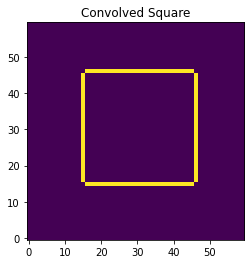

In [11]:
plt.imshow(sq,origin='lower')
plt.title('Convolved Square')
plt.show()

## Simulating Triesmann Experiment

**Triesmann experiment of Visual Search** :-  In the following section we'll be trying to simulate Triesmann's experiment on visual search, and to perform a visual search, we'll be using our bank of filters or complex cell of Visual Cortex we've developed in the prior section. The experiment primarily focuses on 2 types of search paradgims viz. Feature and Conjunction search, we'll be discussing more on those paradigms as we move forward.

In [12]:
def draw(window, shape, color, pos):
    
    '''A module dedicated to create figures based on the input features like shape or color'''
    
    if(shape==0):
        rr,cc=triangle(pos[0],pos[1])
        
    else:
        rr,cc=squares(pos[0],pos[1])
        
    if(color==0):
        col=(1,0,0)
        
    else:
        col=(0,0,1)
        
    
    rr,cc=polygon(rr,cc,window.shape)
    window[rr,cc,:]=col
    
    return window
            

In [13]:
#Max number of objects =25
window=np.ones((300,300,3))

centre_pos=[]
r0,c0=30,30
pos0=[r0,c0]
for i in range(1,26):
    centre_pos.append(pos0)
    c0=np.mod(c0+60,300)
    if(i%5==0):
        r0+=60
    pos0=(r0,c0)

centre_pos

[[30, 30],
 (30, 90),
 (30, 150),
 (30, 210),
 (30, 270),
 (90, 30),
 (90, 90),
 (90, 150),
 (90, 210),
 (90, 270),
 (150, 30),
 (150, 90),
 (150, 150),
 (150, 210),
 (150, 270),
 (210, 30),
 (210, 90),
 (210, 150),
 (210, 210),
 (210, 270),
 (270, 30),
 (270, 90),
 (270, 150),
 (270, 210),
 (270, 270)]

In [14]:
idx=np.random.choice(25, size=4, replace=False)
centre_pos=np.array(centre_pos)


In [15]:
filter_cent=centre_pos[idx,:]
filter_cent

array([[150, 270],
       [210, 210],
       [270, 210],
       [210,  30]])

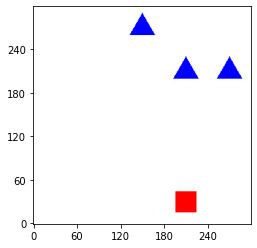

In [16]:
# sq=filter_cent[3]
for i in range(len(filter_cent)-1):
    rr,cc=triangle(filter_cent[i][0],filter_cent[i][1])

    rr,cc=polygon(rr,cc, window.shape)

    window[rr,cc,:]=(0,0,1)


rr,cc=squares(filter_cent[i+1][0],filter_cent[i+1][1])
rr,cc=polygon(rr,cc,window.shape)
window[rr,cc,:]=(1,0,0)
 
fig,ax=plt.subplots()

x_ticks=range(0,300,60)
y_ticks=range(0,300,60)
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
ax.imshow(window,origin='lower')
plt.show()

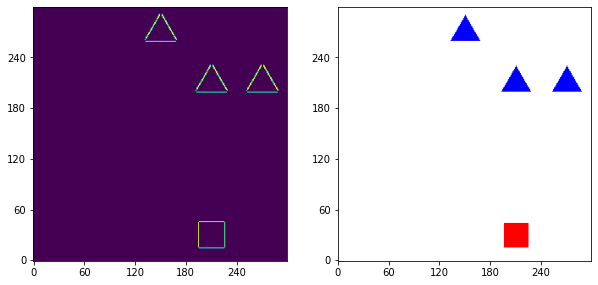

In [17]:
r0,c0=0,0
detect_window=np.ones((300,300))
for i in range(25):
    r0=int(i*60/300)*60
    c0=np.mod(i*60,300)
    
    detect_window[r0:r0+60, c0:c0+60],_=filter_bank(deepcopy(window[r0:r0+60, c0:c0+60]),plot=False)
    
   
fig,ax=plt.subplots(1,2,figsize=[10,5])

x_ticks=range(0,300,60)
y_ticks=range(0,300,60)
ax[0].set_xticks(x_ticks)
ax[0].set_yticks(y_ticks)
ax[0].imshow(detect_window,origin='lower')
ax[1].set_xticks(x_ticks)
ax[1].set_yticks(y_ticks)
ax[1].imshow(window,origin='lower')
plt.show()

In [99]:
def pre_attention(window):
    
    #color : 0=Red, 1=Blue, 2=White/Empty
    store=[]
    feature=[]
    flag=0
    
    for i in range(25):
        r0=int(i*60/300)*60
        c0=np.mod(i*60,300)

        if (window[r0:r0+60, c0:c0+60,0].all()==1 and window[r0:r0+60, c0:c0+60,2].all()==0):
            
            color=0
            
        elif (window[r0:r0+60, c0:c0+60,2].all()==1 and window[r0:r0+60, c0:c0+60,0].all()==0):
            color=1
            
            
        else:
            color=2
        
        if(color!=2):   
            store.append([r0,c0])
            
    
    time.sleep(0.001)  #Neural processing delay
    for i in range(25):
        r0=int(i*60/300)*60
        c0=np.mod(i*60,300)
        _,detected_fig=filter_bank(deepcopy(window[r0:r0+60, c0:c0+60]),plot=False)
        
        if(detected_fig=="Triangle"):
            detected_fig=0
            
        elif(detected_fig=="Square"):
            detected_fig=1
            
        else:
            detected_fig=2
            
        if (window[r0:r0+60, c0:c0+60,0].all()==1 and window[r0:r0+60, c0:c0+60,2].all()==0):
            
            color=0
            
        elif (window[r0:r0+60, c0:c0+60,2].all()==1 and window[r0:r0+60, c0:c0+60,0].all()==0):
            color=1
            
            
        else:
            color=2
        
        if(color!=2):   
            store.append([r0,c0])
            
        if(color!=2 and [detected_fig,color] not in feature ):
            
            if(flag==1):
                return (r0,c0),store
                
            flag=1
            
        feature.append([detected_fig,color])
            
            
     
    return (0,0),store
        
    
    
def Triesman_simulator(window, expt, features, pre_at, plot=False ):
    
    '''Simulates Triesman's Feature and Conjunction search paradigm'''
   
    win2=deepcopy(window)
    
    if(expt=='Feature Search'):
        
        '''Pre_attention pops out the object of desire and we need to search no more'''
        r0,c0=pre_at
        potential_win,detected_fig=filter_bank(deepcopy(window[r0:r0+60, c0:c0+60]),plot=False)
        win2[r0:r0+60, c0:c0+60,np.random.randint(3)]=potential_win
    
    elif(expt=='Conjunction Search'):
        
        '''Preattention helps in estimating no. of objects and we iterate over all objects serially to find our solution'''
        for i in range(len(pre_at)):
            time.sleep(0.001)
           
            r0,c0=pre_at[i][0],pre_at[i][1] 
            
            if(features[0]!=0 and (window[r0:r0+60, c0:c0+60,0].all()==1 and window[r0:r0+60, c0:c0+60,2].all()==0)):
       
                continue
            
            elif(features[0]!=1 and (window[r0:r0+60, c0:c0+60,2].all()==1 and window[r0:r0+60, c0:c0+60,0].all()==0)):
        
                continue
        
            potential_win,detected_fig=filter_bank(deepcopy(window[r0:r0+60, c0:c0+60]),plot=False)
            
            if(detected_fig=="Triangle"):
                detected_fig=0
                
            elif(detected_fig=='Square'):
                detected_fig=1
            
           
            if(detected_fig==features[1]):
               
                win2[r0:r0+60, c0:c0+60,np.random.randint(3)]=potential_win
                
                
    
      
    
    if(plot==True):
        fig,ax=plt.subplots(1,2,figsize=[10,5])
    
        x_ticks=range(0,300,60)
        y_ticks=range(0,300,60)
        ax[0].set_xticks(x_ticks)
        ax[0].set_yticks(y_ticks)
        ax[0].imshow(window,origin='lower')
        ax[0].set_title('Original image with Distractors')
        ax[1].set_xticks(x_ticks)
        ax[1].set_yticks(y_ticks)
        ax[1].imshow(win2,origin='lower')
        ax[1].set_title('Popped out image')
        plt.title(expt)
        plt.show()
        


In [ ]:
Triesman_simulator(window,expt, features)

**Feature Search**:- Searching a target which is identifiable by some unqiue feature like color, orientation or size, in a space filled with distractors. There's a "pop out" effect experienced by human visual system, on looking at such an apparatus, and it highly depends on the reaction time of the individual.

**Conjunction Search**:- Searching for targets which matches either the shape or the color or both in the image. This search paradigm contrasts with the previous search paradigm in the sense that for the previous paradigm both the features as desired by user, should match with the target.

In [104]:
'''Used for taking inputs from user'''

expt=input('Enter Experiment type:')
obj=int(input('Enter number of objects with max number of objects<=25:'))
features=(int(input('Press 0: for red, Press 1:for blue:')), int(input('Press 0:for Triangle, Press 1 for Square:')))


Enter Experiment type:Feature Search
Enter number of objects with max number of objects<=25:8
Press 0: for red, Press 1:for blue:1
Press 0:for Triangle, Press 1 for Square:0


In [49]:

def generate_paradigm(expt, obj, features, centre_pos, plot=False):
    
    window=np.ones((300,300,3))
    idx=np.random.choice(25, size=obj, replace=False)
    centre_pos=np.array(centre_pos)
    ftr=[-1,-1]
    filter_cent=centre_pos[idx,:]
    fixed_feature=np.random.randint(2) #0 indicates color will be fixed, 1 indicates shape will be fixed

    bins=["00", "01", "10", "11"] #List of possible color,shape combos
        
    bins.remove(str(1-features[0])+str(1-features[1]))
    bins.remove(str(features[0])+str(features[1]))

    for i in range(len(filter_cent)-1):
    
        if(expt=='Feature Search'):
        
            ftr[fixed_feature]=features[fixed_feature]
            ftr[1-fixed_feature]=1-features[1-fixed_feature]
        
        else:
            
            
            choice=bins[np.random.randint(2)]
        
            ftr[0]=int(choice[0])
            ftr[1]=int(choice[1])
        
        
    
        window=draw(window,ftr[1], ftr[0], (filter_cent[i][0],filter_cent[i][1]))
    
              
    window=draw(window,features[1],features[0],(filter_cent[i+1][0],filter_cent[i+1][1]))
    
    if(plot==True):
        fig,ax=plt.subplots()

        x_ticks=range(0,300,60)
        y_ticks=range(0,300,60)
        ax.set_xticks(x_ticks)
        ax.set_yticks(y_ticks)
        ax.imshow(window,origin='lower')
        plt.show()
        
    return window
        


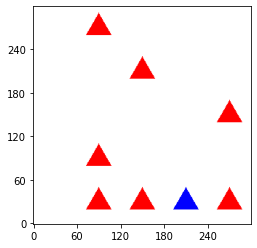

In [105]:
window=generate_paradigm(expt, obj, features, centre_pos, plot=True )

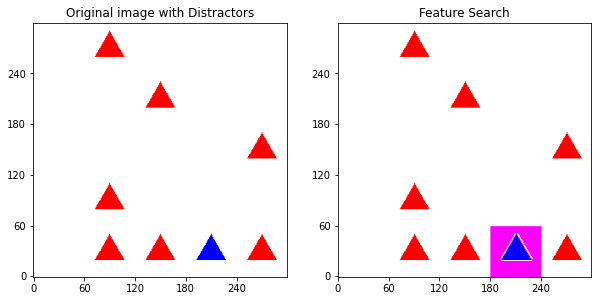

In [106]:
#For Feature Search
pre_at,_=pre_attention(window)

Triesman_simulator(window, expt, features, pre_at, plot=True)

The above plot demonstrates how Feature search is able to locate our desired object among all the distractors.

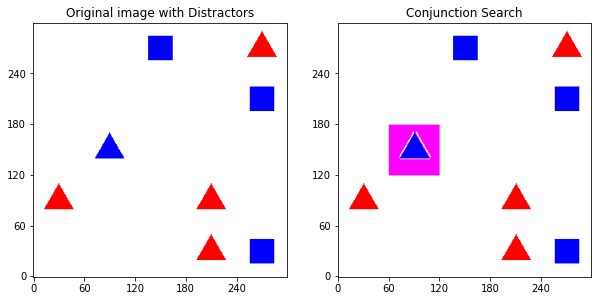

In [93]:
#For Conjunction Search
_, pre_at=pre_attention(window)

Triesman_simulator(window, expt, features, pre_at, plot=True)

The above plot demonstrates how Conjunction search is able to locate our desired object among all the distractors.

## Feature Integration Theory

In the following section we'll be using the functions defined above to find out time taken for Feature Integration in 2 types of experiment, namely, Feature Search and Conjunction Search. We'll be observing how the response time behaves on increasing number of distractors in the image.

In [100]:
'''We'll assume our desired feature is blue square or [1,1] for our experiments below '''

#Feature Search
responsetimefeature=[]
expt="Feature Search"

for obj in range(2,24):
    
    window=generate_paradigm(expt, obj, [1,1], centre_pos )
    pre_at,_=pre_attention(window)
    
    t=time.time()#start of response time#
    Triesman_simulator(window, expt, [1,1], pre_at)
    responsetimefeature.append(time.time()-t)

    
#Conjuction Search#
responsetimeconjuction=[]
expt="Conjunction Search"
for obj in range(2,24):
    
    window=generate_paradigm(expt, obj, [1,1], centre_pos )
    _, pre_at=pre_attention(window)
    
    t=time.time()#start of response time#
    Triesman_simulator(window, expt, [1,1], pre_at)
    responsetimeconjuction.append(time.time()-t)
    


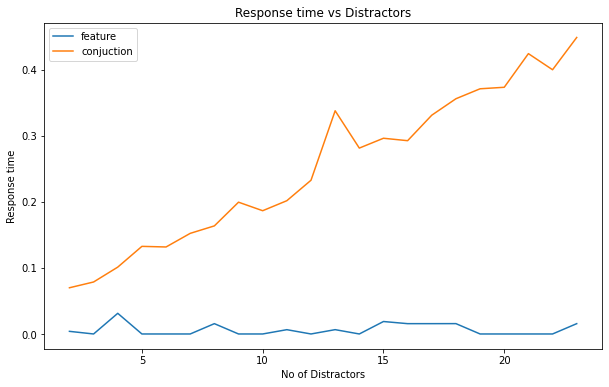

In [103]:
plt.figure(figsize=(10,6))
responsetimes=np.array(responsetimefeature)
responsetimes2=np.array(responsetimeconjuction)
plt.plot([i for i in range(2,24)],responsetimes)
plt.plot([i for i in range(2,24)],responsetimes2)
plt.legend(["feature","conjuction"],loc=2)
plt.xlabel("No of Distractors")
plt.ylabel("Response time")
plt.title("Response time vs Distractors")
plt.savefig('ResponseGraph.png', bbox_inches='tight')
plt.show()

**Inference from the above graph**:- We can an uptrend of response time as no. of distractors also increase, this happens as in Conjunction search, a serial search is performed acroos all the objects and by combining features we're able to find the object we desire. In Feature Search, however, the Response Time generally remains constant, as the "pop-out" effect takes place and the search happens even without any conscious attention( in the preattention stage).

## References

1. https://en.wikipedia.org/wiki/Visual_search
2. https://www.youtube.com/watch?v=3QFaTrS4Xnw
3. https://en.wikipedia.org/wiki/Gabor_filter

## Acknowledgements

I am really thankful to my friends Manjyot and Sharanya for being wonderful partners in discussion and brainstorming